In [1]:
import cv2
import os
import numpy as np

# Paths to preprocessed data
frames_dir = r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\training\frames'
masks_dir = r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\training\lane-masks'

# Data generator function
def data_generator(frames_dir, masks_dir, batch_size=32, img_size=(128, 128)):
    image_files = os.listdir(frames_dir)
    mask_files = os.listdir(masks_dir)
    
    while True:
        indices = np.random.permutation(len(image_files))
        
        for start in range(0, len(image_files), batch_size):
            end = min(start + batch_size, len(image_files))
            batch_indices = indices[start:end]

            batch_images = []
            batch_masks = []
            
            for i in batch_indices:
                img_path = os.path.join(frames_dir, image_files[i])
                mask_path = os.path.join(masks_dir, mask_files[i])
                
                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                img_resized = cv2.resize(img, img_size) / 255.0
                mask_resized = cv2.resize(mask, img_size) / 255.0

                batch_images.append(img_resized)
                batch_masks.append(mask_resized)

            yield np.array(batch_images), np.array(batch_masks)


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ENet model definition
def enet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    e1 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    e1 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(e1)
    e1_pool = layers.MaxPooling2D((2, 2))(e1)

    e2 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(e1_pool)
    e2 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(e2)
    e2_pool = layers.MaxPooling2D((2, 2))(e2)

    e3 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(e2_pool)
    e3 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(e3)
    e3_pool = layers.MaxPooling2D((2, 2))(e3)

    # Bottleneck
    b = layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same')(e3_pool)
    b = layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    d1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    d1 = layers.concatenate([d1, e3])
    d1 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(d1)
    d1 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(d1)

    d2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d1)
    d2 = layers.concatenate([d2, e2])
    d2 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(d2)
    d2 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(d2)

    d3 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(d2)
    d3 = layers.concatenate([d3, e1])
    d3 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(d3)
    d3 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(d3)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d3)

    model = models.Model(inputs, outputs)
    return model


Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 145s 627ms/step - accuracy: 0.9188 - loss: 0.4396 - val_accuracy: 0.9431 - val_loss: 0.1664
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 149s 660ms/step - accuracy: 0.9431 - loss: 0.1540 - val_accuracy: 0.9431 - val_loss: 0.1327
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 149s 661ms/step - accuracy: 0.9435 - loss: 0.1245 - val_accuracy: 0.9447 - val_loss: 0.1087
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 149s 660ms/step - accuracy: 0.9450 - loss: 0.1036 - val_accuracy: 0.9460 - val_loss: 0.0922
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 146s 649ms/step - accuracy: 0.9459 - loss: 0.0912 - val_accuracy: 0.9478 - val_loss: 0.0824
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 142s 631ms/step - accuracy: 0.9478 - loss: 0.0816 - val_accuracy: 0.9487 - val_loss: 0.0759
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 134s 592ms/step - accuracy: 0.9492 - loss: 0.0761 - val_accuracy: 0.9505 - val_loss: 0.0718
Epoch 8/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 115s 510ms/step - accuracy: 0.9499 -

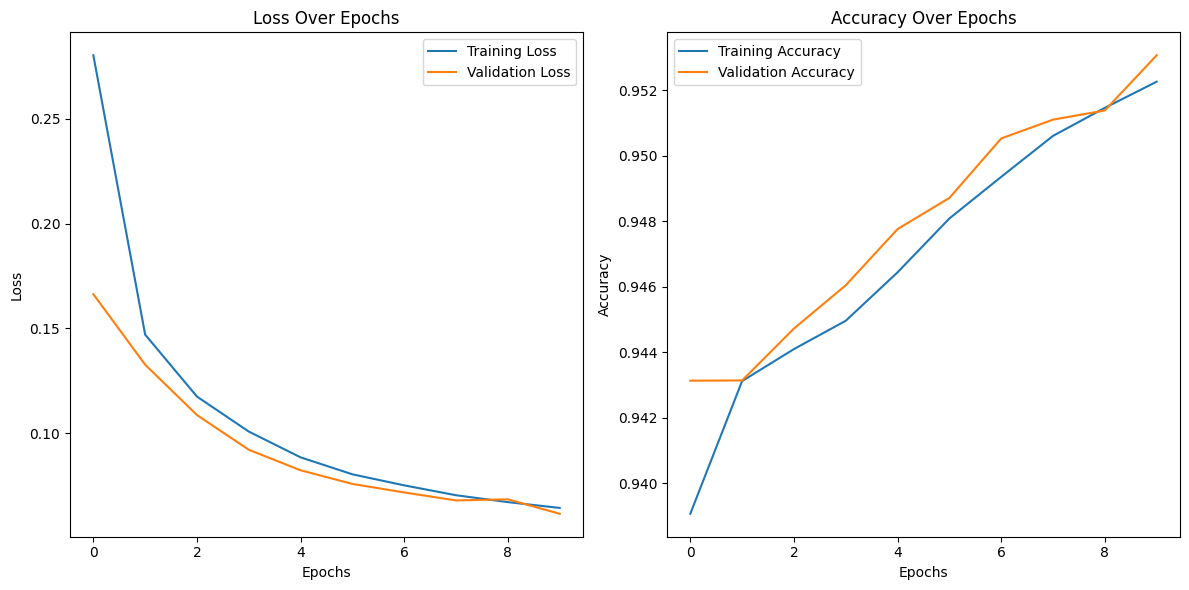

In [4]:
import matplotlib.pyplot as plt

# Initialize the model
model = enet_model()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Batch size and epochs
batch_size = 16
epochs = 10

# Training and validation generators
train_gen = data_generator(frames_dir, masks_dir, batch_size=batch_size)
val_gen = data_generator(frames_dir, masks_dir, batch_size=batch_size)  # Replace with actual validation data if available

# Train the model
history = model.fit(train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=len(os.listdir(frames_dir)) // batch_size,
                    validation_steps=len(os.listdir(masks_dir)) // batch_size,
                    epochs=epochs)

# Save the model in the recommended Keras format with .keras extension
model_save_path = 'enet_saved_model.keras'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the best saved model
model = tf.keras.models.load_model(r'C:\Users\adidi\Downloads\ENet\enet_saved_model.keras', compile=False)

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import json

# Path to the JSON file for the test set
test_annotations_path = r'C:\Users\adidi\Downloads\ENet\TUSimple\test_set\test_label.json'

# Paths to save the generated masks and frames
test_mask_path = r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\test\lane-masks'
test_frame_path = r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\test\frames'

# Ensure the directories exist
os.makedirs(test_mask_path, exist_ok=True)
os.makedirs(test_frame_path, exist_ok=True)

def generate_lane_mask(row, training_set=True):
    '''
        Generates and writes the corresponding lane masks for the given images.
    '''
    # Create a mask of all zeros (720x1280, which is the resolution for TUSimple dataset)
    mask = np.zeros((720, 1280, 3), dtype=np.uint8)  # Ensuring proper dtype for mask
    h_samples = row['h_samples']  # Horizontal sample positions
    lanes = row['lanes']  # Lane markings
    raw_file = row['raw_file']  # Raw file path

    # Create mask: lane: 1, non-lane: 0
    for lane in lanes:
        # -2 indicates no line in the specified point, so we omit these points
        h_samples_updated = [y for x, y in zip(lane, h_samples) if x != -2]
        lane = [x for x in lane if x != -2]
        lane_points = np.array(list(zip(lane, h_samples_updated)))

        # Add lane markings to the mask we created (white line for lane)
        cv2.polylines(mask, [lane_points], False, (255, 255, 255), thickness=15)

    # Define the path where lane masks will be stored
    path = test_mask_path if not training_set else r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\training\lane-masks'
    
    # Name each mask according to its image's name
    tmp = raw_file[:-7].split('/')[-2:]
    mask_fname = f'{tmp[0]}_{tmp[1]}.jpg'
    new_file = os.path.join(path, mask_fname)
    
    # Save the mask image
    cv2.imwrite(new_file, mask)

    return mask_fname

# Process the test set JSON file
data = []

with open(test_annotations_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

# Convert JSON data to DataFrame for easier processing
df = pd.DataFrame(data)

# Loop through each row in the DataFrame to generate lane masks and save frames
for index, row in df.iterrows():
    # Generate the lane mask for the current frame
    mask_fname = generate_lane_mask(row, training_set=False)
    
    # Save the corresponding frame
    raw_file = row['raw_file']
    frame_path = os.path.join(r'C:\Users\adidi\Downloads\ENet\TUSimple\test_set', raw_file.replace('/', os.sep))
    frame = cv2.imread(frame_path)
    if frame is not None:
        frame_fname = os.path.join(test_frame_path, mask_fname)
        cv2.imwrite(frame_fname, frame)
    else:
        print(f"Frame not found: {frame_path}")

    # Print progress every 200 rows
    if index % 200 == 0:
        print(f"Processed Row: {index} from test JSON")

print("Test lane masks and frames generated successfully!")


Processed Row: 0 from test JSON
Processed Row: 200 from test JSON
Processed Row: 400 from test JSON
Processed Row: 600 from test JSON
Processed Row: 800 from test JSON
Processed Row: 1000 from test JSON
Processed Row: 1200 from test JSON
Processed Row: 1400 from test JSON
Processed Row: 1600 from test JSON
Processed Row: 1800 from test JSON
Processed Row: 2000 from test JSON
Processed Row: 2200 from test JSON
Processed Row: 2400 from test JSON
Processed Row: 2600 from test JSON
Test lane masks and frames generated successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


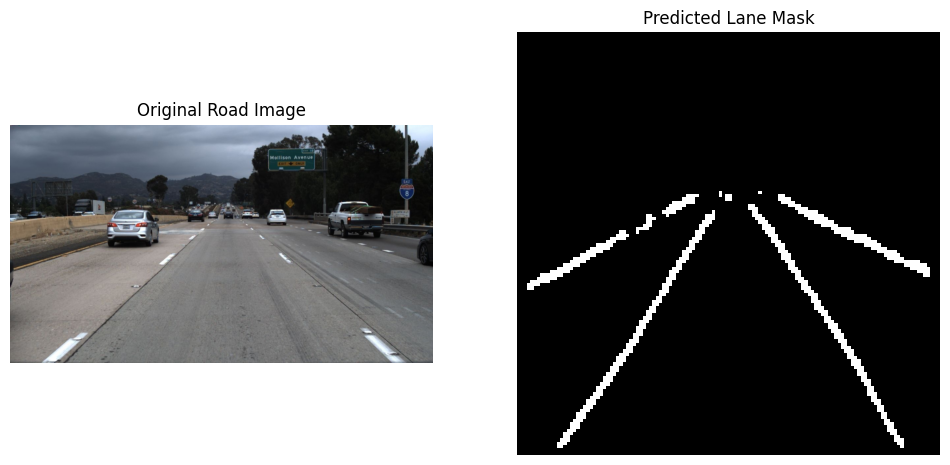

In [1]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Path to the trained model
model_path = r'C:\Users\adidi\Downloads\ENet\enet_saved_model.keras'  # Change this to your model path
model = load_model(model_path)

# Function to load and preprocess the input image
def preprocess_image(image_path, img_size=(128, 128)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image: {image_path}")
        return None
    
    # Resize image to the expected input size and normalize it to [0, 1]
    image_resized = cv2.resize(image, img_size) / 255.0
    return image_resized

# Function to predict lane mask for a given image
def predict_lane_mask(model, image_path, img_size=(128, 128)):
    # Preprocess the input image
    img_resized = preprocess_image(image_path, img_size)
    
    if img_resized is None:
        return None
    
    # Add batch dimension (model expects batch of images)
    img_input = np.expand_dims(img_resized, axis=0)
    
    # Make prediction using the trained model
    prediction = model.predict(img_input)[0]  # Get the prediction (remove batch dimension)
    
    # Post-process the prediction (e.g., thresholding for binary segmentation)
    prediction = (prediction > 0.5).astype(np.uint8)  # Convert to binary mask (0 or 1)
    
    return prediction

# Function to display the input image and the predicted lane mask
def display_prediction(image_path, prediction):
    # Load original image to show
    image = cv2.imread(image_path)
    
    # Display the original image and the predicted mask
    plt.figure(figsize=(12, 6))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Road Image")
    plt.axis('off')
    
    # Show predicted lane mask
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='gray')
    plt.title("Predicted Lane Mask")
    plt.axis('off')
    
    plt.show()

# Path to the road image you want to predict lane mask for
image_path = r'C:\Users\adidi\Downloads\ENet\tusimple_preprocessed\test\frames\0601_1494453475619239031.jpg'  # Replace with your image path

# Get prediction for lane mask
prediction = predict_lane_mask(model, image_path)

# If prediction is successful, display the result
if prediction is not None:
    display_prediction(image_path, prediction)
